# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gym: https://github.com/openai/gym 

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

# Implementation of the Windy GridWorld environment in Example 6.5

In [236]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [237]:
"""Windy GridWorld Env"""
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Args:
            enable_king_move (bool): If True, using King's movement. Otherwise, using the original action space.
            enable_no_move (bool): If True, adding no movement under the condition of enable_king_move = True.
        
        Note: for different setup, we have the following action spaces:
            - Original: ["up", "down", "left", "right"];
            - King's move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"];
            - King's move + no move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right", "stay"]
        """
        
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        if enable_king_move:
            # add King's move actions
            if enable_no_move:
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1]),  # add down-left
                    "stay": np.array([0, 0])  # add no move action
                }
            else:
                # add King's move actions + one no movement action
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1])  # add down-left
                }
        else:
            # normal actions
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        """
        Args:
            act (string): a string variable indicating the action.
        """
        # obtain the state array
        
        s_arr = np.array(self.state)
        # print(s_arr)

        # obtain the action array
        # print(act)
        act_arr = self.action_space[act.lower()]

        # obtain the wind array
        wind_arr = -1 * np.array([self.wind[self.state[1]], 0], dtype=int)

        # compute the next state
        next_s_arr = np.clip(s_arr + act_arr + wind_arr,
                             a_min=np.array([0, 0]),
                             a_max=np.array([self.grid.shape[0]-1, self.grid.shape[1]-1]))

        # compute the reward
        reward = 0 if next_s_arr.tolist() == self.goal_state else -1

        # check the termination
        terminated = True if reward == 0 else False

        # update the tracking variables
        self.state = next_s_arr.tolist()
        self.t += 1
        self.act = act

        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)

In [238]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)
    plt.show()

# Test Windy GridWorld 

In [239]:
# check whether enable King's movement and no movement
use_king_move = False
use_no_move = False

# create the environment
env = WindyGridWorld(enable_king_move=use_king_move,
                     enable_no_move=use_no_move)
s, d = env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    a = np.random.choice(list(env.action_space.keys()), 1)[0]
    
    # interact with the envrionment
    next_s, r, d = env.step(a)
    
    # print info
    print(f"t = {t}: state = {s}, action = {a},  reward = {r}, next_state = {next_s}, done = {d}")
    
    # check termination
    if d:
        s, d = env.reset()

# Q4 - (a): Solve the Windy Gridworld using the following algorithms and reproduce the figure similar to the figure in Example 6.5

- Implement the SARSA, Expected SARSA, and Q learning.
- Reproduce the plot in the Example 6.5 and plot the three curves in a single plot. You can use the provided plotting code.

In [240]:

def arg_max(Q):
    nu=np.array(Q)
    return random.choices(np.flatnonzero(Q==Q.max()))

def selectaction(state,q_values,world,e):
    action=None
    q=[]
    random_number=np.random.rand()
    if (random_number<e):
        action=np.random.choice(list(world.action_space.keys()), 1)[0]
    else:
        for i in world.action_space.keys():
            q.append(q_values[(state,i)])
        max_val=np.argmax(q)
        action=list(world.action_space.keys())[max_val]

    return action


def sarsa(world,alpha,gamma,ep,num_of_run):
    no_of_time_steps=8000
    # num_of_run=10
    episodes=np.zeros((num_of_run,no_of_time_steps))
  
    for i in range (num_of_run):
       # print(i)
        episode=0
        time_step_counter=0
        qsa=defaultdict(int)
        while time_step_counter<no_of_time_steps:
          #  print('counter')
            state,done=world.reset()
            state=tuple(state)
            # print(state)
            action=selectaction(state,qsa,world,ep)
            #  print(action)
            while True:
                next_s,reward,done=world.step(action)
                next_s=tuple(next_s)
                # print(next_s)
                new_action=selectaction(next_s,qsa,world,ep)
            #  print(new_action)
                qsa[(state,action)] += alpha * (reward + gamma * qsa[(next_s,new_action)]-qsa[(state,action)])
                state=next_s
                action=new_action
              
                episodes[i][time_step_counter] = episode
                
                time_step_counter +=1
                if done:

                    episode +=1
                    
                    break

                if time_step_counter==no_of_time_steps:
                
                    break
        
    return episodes


            

    


    


<Figure size 640x480 with 0 Axes>

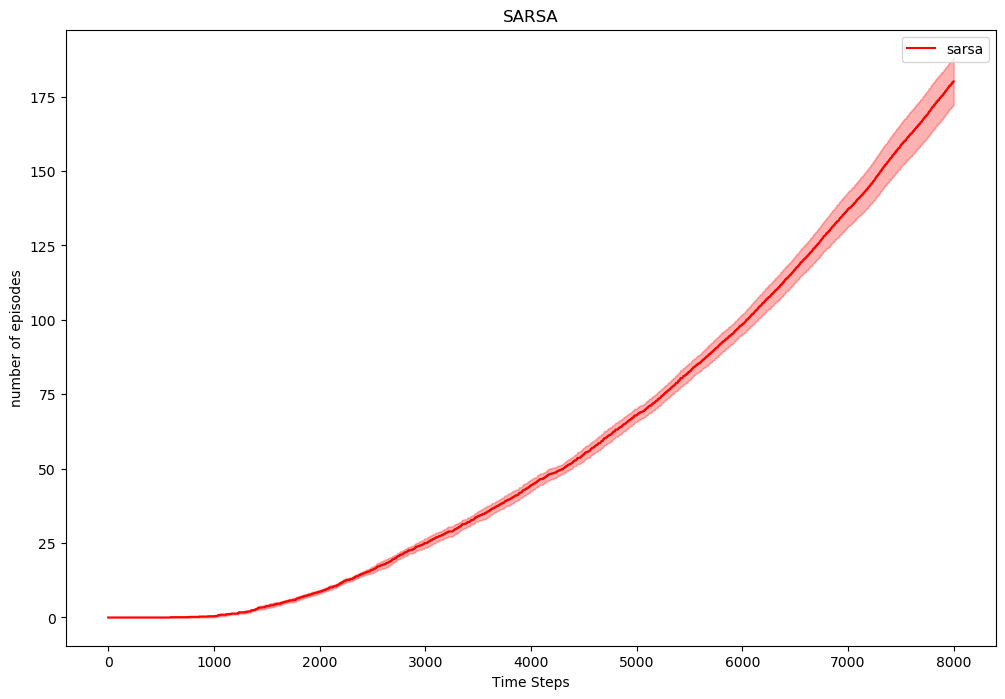

In [241]:
world=WindyGridWorld(enable_king_move=False, enable_no_move=False)
episode=sarsa(world,0.5,0.9,0.1,10)
plot_curves([episode], ['sarsa'], ['r'], 'number of episodes', 'SARSA')


In [242]:

def arg_max(Q):
    nu=np.array(Q)
    return random.choices(np.flatnonzero(Q==Q.max()))

def selectaction(state,q_values,world,e):
    action=None
    q=[]
    random_number=np.random.rand()
    if (random_number<e):
        action=np.random.choice(list(world.action_space.keys()), 1)[0]
    else:
        for i in world.action_space.keys():
            q.append(q_values[(state,i)])
        max_val=np.argmax(q)
        action=list(world.action_space.keys())[max_val]

    return action

def bestaction(state,q_values,world,e):
    q=[]
    for i in world.action_space.keys():
        q.append(q_values[(state,i)])
    max_val=np.argmax(q)
    action=list(world.action_space.keys())[max_val]
    return action


def q_learning(world,alpha,gamma,ep,num_of_run):
    no_of_time_steps=8000
    num_of_run=10
    episodes=np.zeros((num_of_run,no_of_time_steps))
  
    for i in range (num_of_run):
       # print(i)
        episode=0
        time_step_counter=0
        qsa=defaultdict(int)
        while time_step_counter<no_of_time_steps:
        
            state,done=world.reset()
            state=tuple(state)
         
            while True:
                action=selectaction(state,qsa,world,ep)
                next_s,reward,done=world.step(action)
                next_s=tuple(next_s)
                new_action=bestaction(next_s,qsa,world,ep)
                qsa[(state,action)] += alpha * (reward + gamma * qsa[(next_s,new_action)]-qsa[(state,action)])
                state=next_s
                action=new_action
              
                episodes[i][time_step_counter] = episode
                
                time_step_counter +=1
                if done:

                    episode +=1
                    
                    break

                if time_step_counter==no_of_time_steps:
                
                    break
        
    return episodes


            

    


    


<Figure size 640x480 with 0 Axes>

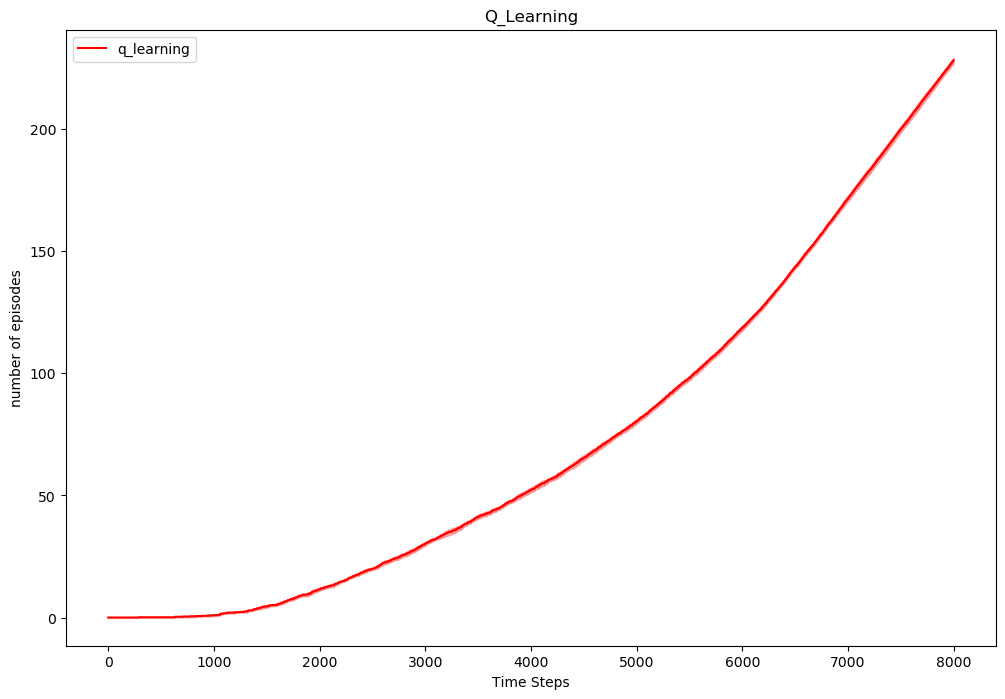

In [243]:
world=WindyGridWorld(enable_king_move=False, enable_no_move=False)
episode=q_learning(world,0.5,0.9,0.1,10)
plot_curves([episode], ['q_learning'], ['r'], 'number of episodes', 'Q_Learning')


In [244]:

def selectaction(state,q_values,world,e):
    action=None
    q=[]
    random_number=np.random.rand()
    if (random_number<e):
        action=np.random.choice(list(world.action_space.keys()), 1)[0]
    else:
        for i in world.action_space.keys():
            q.append(q_values[(state,i)])
        max_val=np.argmax(q)
        action=list(world.action_space.keys())[max_val]

    return action

def prob_actions(state,e,world,q_values):
    m=0
    q=[]
    actions=world.action_space
    p=[e/len(actions)]*len(actions)
    for i in world.action_space.keys():
        q.append(q_values[(state,i)])
    max_val=np.argmax(q)

    p[max_val] += (1-e)
    
    return p

def expected_sarsa(world,alpha,gamma,ep,num_of_run):
    no_of_time_steps=8000
    num_of_run=10
    episodes=np.zeros((num_of_run,no_of_time_steps))
  
    for i in range (num_of_run):
     
        episode=0
        time_step_counter=0
        qsa=defaultdict(int)
        
        while time_step_counter<no_of_time_steps:
        
            state,done=world.reset()
            state=tuple(state)
         
            while True:
                action=selectaction(state,qsa,world,ep)
                next_s,reward,done=world.step(action)
                next_s=tuple(next_s)
                p=prob_actions(next_s,ep,world,qsa)
                expected_q=sum([p[i]*qsa[(next_s,a)] for i,a in enumerate (world.action_space.keys())])
                qsa[(state,action)] += alpha * (reward + gamma * expected_q-qsa[(state,action)])
                state=next_s
              
                episodes[i][time_step_counter] = episode
                
                time_step_counter +=1
                if done:
                    episode +=1
                    break

                if time_step_counter==no_of_time_steps:
                
                    break
        
    return episodes


            

    


    


<Figure size 640x480 with 0 Axes>

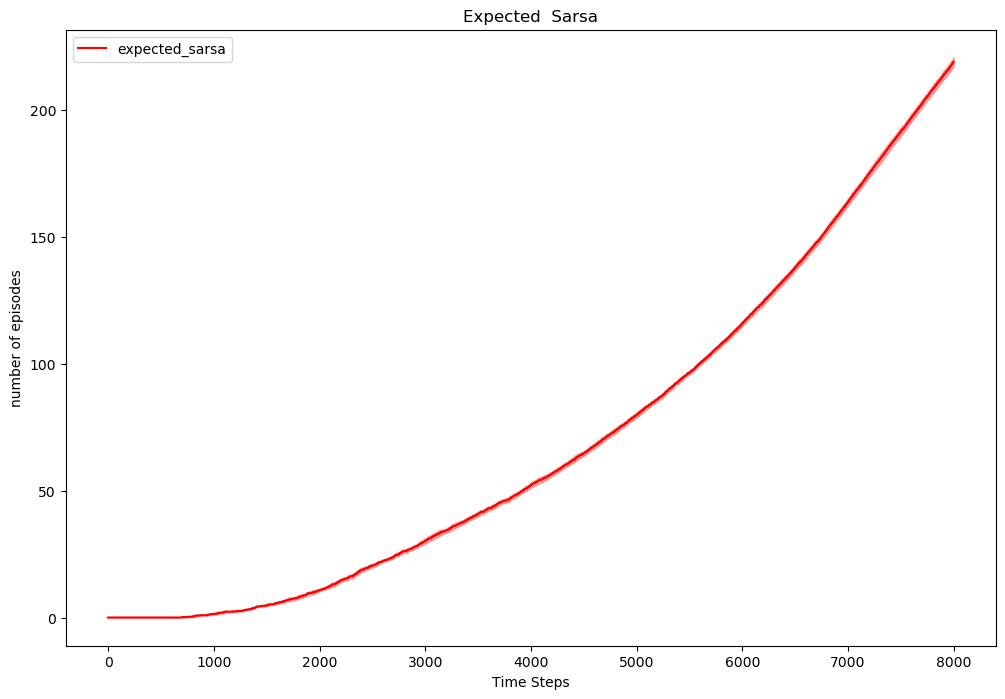

In [245]:
""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """
world=WindyGridWorld(enable_king_move=False, enable_no_move=False)
episode=expected_sarsa(world,0.5,0.9,0.1,10)
plot_curves([episode], ['expected_sarsa'], ['r'], 'number of episodes', 'Expected  Sarsa')


<Figure size 640x480 with 0 Axes>

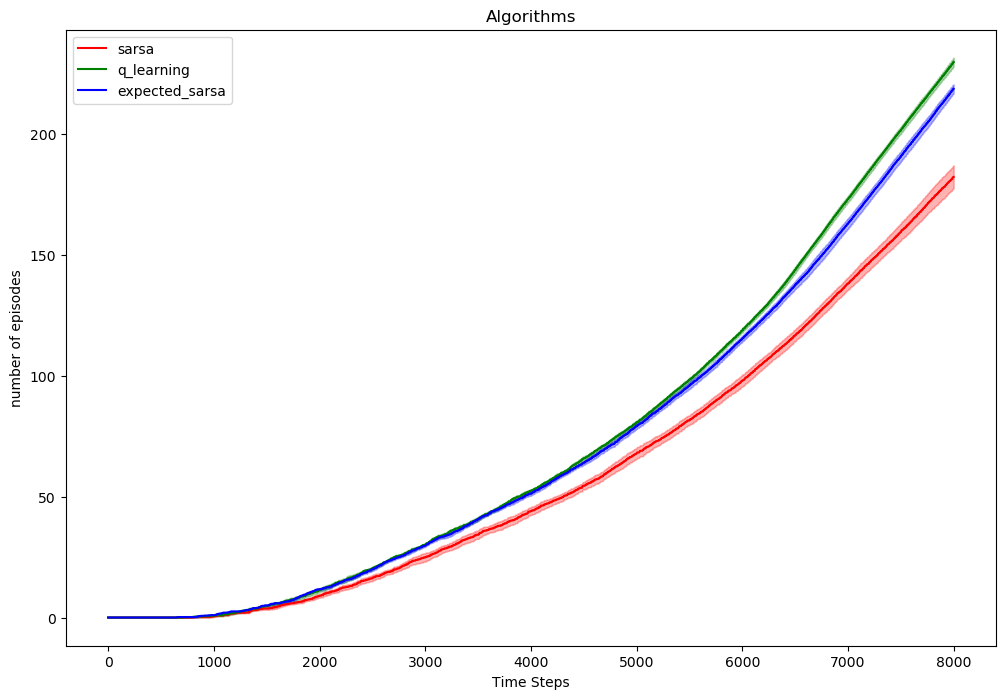

In [246]:
world=WindyGridWorld(enable_king_move=False, enable_no_move=False)
episode1=sarsa(world,0.5,0.9,0.1,10)
episode2=q_learning(world,0.5,0.9,0.1,10)
episode3=expected_sarsa(world,0.5,0.9,0.1,10)
plot_curves([episode1,episode2,episode3], ['sarsa','q_learning','expected_sarsa'], ['r','g','b'], 'number of episodes', 'Algorithms')

# Q4 - (b): Re-solve the Windy GridWorld with Kings' movement and No movement.

<Figure size 640x480 with 0 Axes>

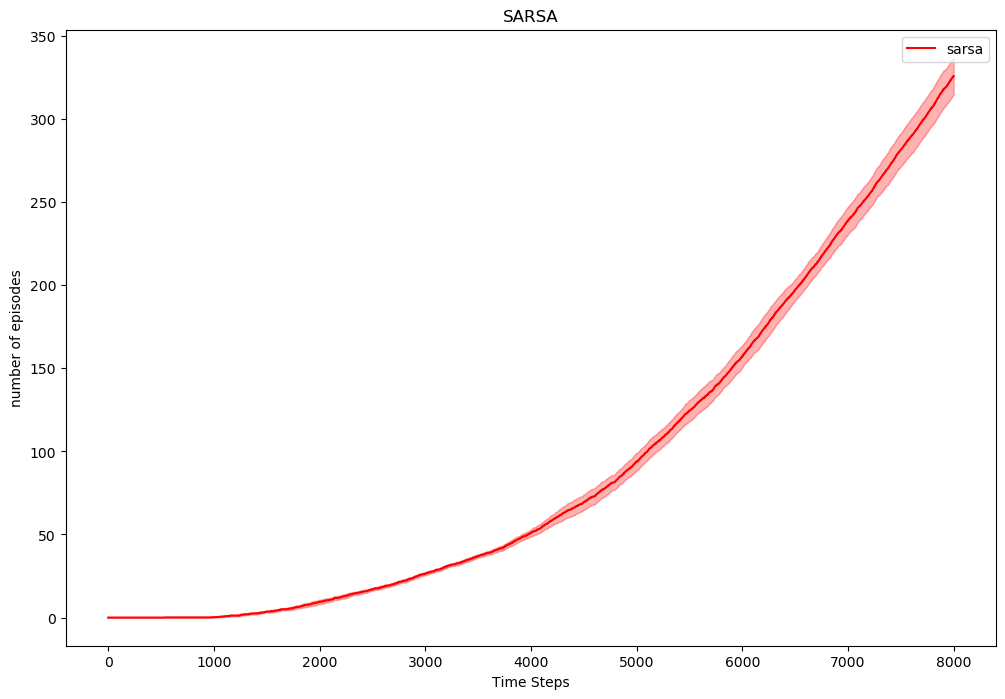

In [247]:
""" Reproduce the Figure above in Windy GridWorld with King's movement """

""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """
world=WindyGridWorld(enable_king_move=True, enable_no_move=False)
episode=sarsa(world,0.5,0.9,0.1,10)
plot_curves([episode], ['sarsa'], ['r'], 'number of episodes', 'SARSA')


<Figure size 640x480 with 0 Axes>

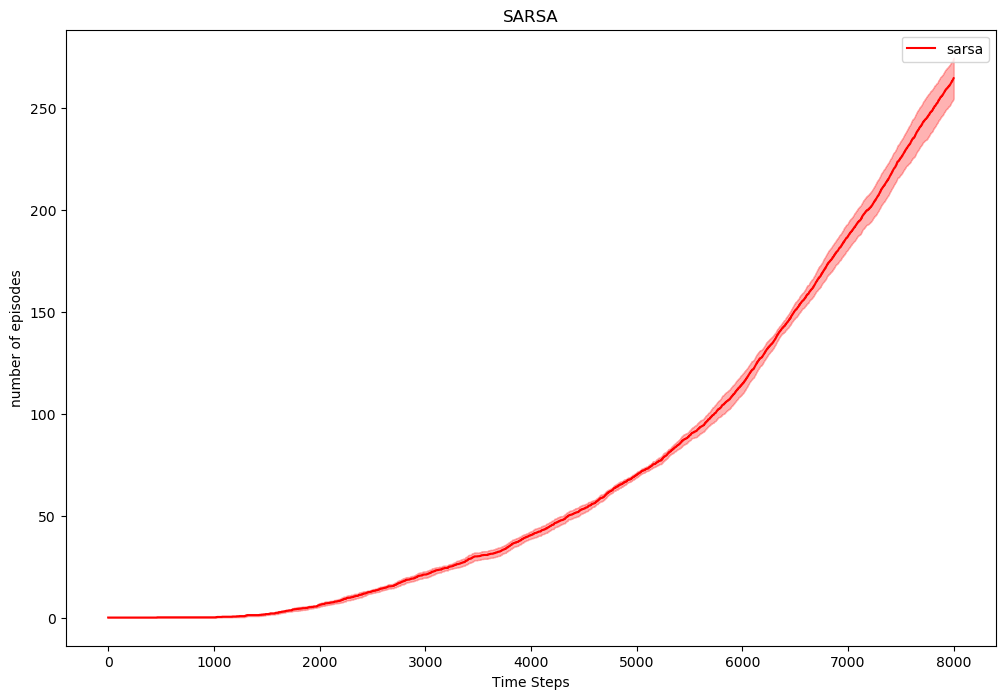

In [248]:
""" Reproduce the Figure above in Windy GridWorld with King's movement + no movement """

""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """
world=WindyGridWorld(enable_king_move=True, enable_no_move=True)
episode=sarsa(world,0.5,0.9,0.1,10)
plot_curves([episode], ['sarsa'], ['r'], 'number of episodes', 'SARSA')


# Q5: Bias-variance trade-off

In [249]:
""" Please code your implementation of running the experiments here """

def arg_max(Q):
    nu=np.array(Q)
    return random.choices(np.flatnonzero(Q==Q.max()))

def selectaction(state,q_values,world,e):
    action=None
    q=[]
    random_number=np.random.rand()
    if (random_number<e):
        action=np.random.choice(list(world.action_space.keys()), 1)[0]
    else:
        for i in world.action_space.keys():
            q.append(q_values[(state,i)])
        max_val=np.argmax(q)
        action=list(world.action_space.keys())[max_val]

    return action


def sarsa_q5(world,alpha,gamma,ep,num_of_run):
    no_of_time_steps=8000
    episodes=np.zeros((num_of_run,no_of_time_steps))
  
    for i in range (num_of_run):
       # print(i)
        episode=0
        time_step_counter=0
        qsa=defaultdict(int)
        while time_step_counter<no_of_time_steps:
          #  print('counter')
            state,done=world.reset()
            state=tuple(state)
            # print(state)
            action=selectaction(state,qsa,world,ep)
            #  print(action)
            while True:
                next_s,reward,done=world.step(action)
                next_s=tuple(next_s)
                # print(next_s)
                new_action=selectaction(next_s,qsa,world,ep)
            #  print(new_action)
                qsa[(state,action)] += alpha * (reward + gamma * qsa[(next_s,new_action)]-qsa[(state,action)])
                state=next_s
                action=new_action
              
                episodes[i][time_step_counter] = episode
                
                time_step_counter +=1
                if done:

                    episode +=1
                    
                    break

                if time_step_counter==no_of_time_steps:
                
                    break
        
    return qsa,episodes


        

In [250]:

def selectaction(state,q_values,world,e):
    action=None
    q=[]
    random_number=np.random.rand()
    if (random_number<e):
        action=np.random.choice(list(world.action_space.keys()), 1)[0]
    else:
        for i in world.action_space.keys():
            q.append(q_values[(state,i)])
        max_val=np.argmax(q)
        action=list(world.action_space.keys())[max_val]

    return action

def training(world,qsa_10,num_of_rep,ep):
    sar=[]
    
    for rep in range(num_of_rep):
        sar_inner = []
        done = True
        reward = None
        while True:
            if done:
                state, done = world.reset()
            else:
                state, reward, done = world.step(action)

            state = tuple(state)
            action = selectaction(state, qsa_10, world, ep)
            sar_inner.append((state, action, reward))

            if done :
                break

        sar.append(sar_inner)
        
    return sar
            
            
        
        

In [251]:



def td0(epi_tuples,alpha, gamma):
    V = defaultdict(float)

    for ep in epi_tuples:
        for i in range(len(ep)-1):
            curr_state = ep[i][0]
            next_state = ep[i+1][0]
            reward = ep[i+1][2]

            V[curr_state] += alpha * (reward + gamma * V[next_state] - V[curr_state])

    return V

def mc(epi_tuples,gamma):
    V=defaultdict(float)
    returns= defaultdict(float)
    counts = defaultdict(int)
    k=0
    
    for ep in epi_tuples:
        G=0
        for i in range(len(ep)-2,-1,-1):
            curr_state=ep[i][0]
            reward=ep[i+1][2]
            G=gamma*G + reward
            
            for j in range(i):
                if ep[j][0]==curr_state:
                    break
            if j==i: 
                counts[curr_state] +=1
                returns[curr_state] += G
                
                V[curr_state] = returns[curr_state] / counts[curr_state]
        
    return V
                    
                    

def mctarget(epi_tuples,gamma, env):
    V=defaultdict(float)
    k=0
    targets=[]
    
    for ep in epi_tuples:
        G=0
        for i in range(len(ep)-2,-1,-1):
            curr_state=ep[i][0]
            reward=ep[i+1][2]
            G=gamma*G + reward
            
            for j in range(i):
                if ep[j][0]==curr_state:
                    break
            if j==i and curr_state == tuple(env.start_state): 
                targets.append(G)
    return targets

def tdtarget(episodes,V, gamma, env):
    targets = []
    for ep in episodes:
        for i in range(len(ep)-1):
            curr_state = ep[i][0]
            next_state = ep[i+1][0]
            reward = ep[i+1][2]

            if curr_state == tuple(env.start_state):
                targets.append(reward + gamma * V[next_state])
                break
    return targets
                

        
        

In [297]:

def valueiter(world, threshold,gamma, delta,N):

    state_value = np.zeros((7, 10))

    iter_counter = 0
    p=1

    for i in range(N):

        is_terminal = True
        delta=0
        new_state_value = np.zeros_like(state_value)
        iter_counter+=1

        for i in range(7):
            for j in range(10):
                current_state=[i,j]
                old_v=state_value[i,j]
                new_v=[]
                for action in world.action_space:
                    # print(action)
                    next_s,r,done=world.step(action)
                    # print(next_s)
                    new_v.append((r+gamma*state_value[next_s[0],next_s[1]]))
                new_v=np.array(new_v)
                new_value=np.max(new_v)
              
                if abs(new_value-old_v)>threshold:
                    is_terminal=False
                new_state_value[i, j] = new_value

        state_value = new_state_value.copy()

        if is_terminal:
            print('numbner of iteration', iter_counter)
            break
        iter_counter +=1

    return state_value[world.start_state[0], world.start_state[1]]


In [301]:
""" Please code your implementation of plotting the histogram figure here """
world=WindyGridWorld(enable_king_move=False, enable_no_move=False)
# qsa_1,ep_1=sarsa_q5(world,0.5,0.9,0.1,1)
qsa_10,ep_10=sarsa_q5(world,0.5,0.9,0.1,10)
# qsa_50,ep_50=sarsa_q5(world,0.5,0.9,0.1,50)
sar1=training(world,qsa_10,1,0.1)
sar10=training(world,qsa_10,10,0.1)
sar50=training(world,qsa_10,50,0.1)
vtd1=td0(sar1,0.5,0.9)
vtd10=td0(sar10,0.5,0.9)
vtd50=td0(sar50,0.5,0.9)
vmc1=mc(sar1,0.9)
vmc10=mc(sar10,0.9)
vmc50=mc(sar50,0.9)
evaluation_episodes = training(world, qsa_10, 100, 0.1)
mct1=mctarget(evaluation_episodes,1,world)
mct10=mctarget(evaluation_episodes,1,world)
mct50=mctarget(evaluation_episodes,1,world)
tdt1=tdtarget(evaluation_episodes,vtd1,0.9,world)
tdt10=tdtarget(evaluation_episodes,vtd10,1,world)
tdt50=tdtarget(evaluation_episodes,vtd50,1,world)
v1=valueiter(world,0,0.9, 0,1)
v10=valueiter(world,0,0.9, 0,10)
v50=valueiter(world,0,0.9, 0,50)
assert len(mct1) == 100 and len(mct10) == 100 and len(mct50) == 100, (len(mct1), len(mct10), len(mct50))
assert len(tdt1) == 100 and len(tdt10) == 100 and len(tdt50) == 100, (len(tdt1), len(tdt10), len(tdt50))



<function matplotlib.pyplot.show(*args, **kw)>

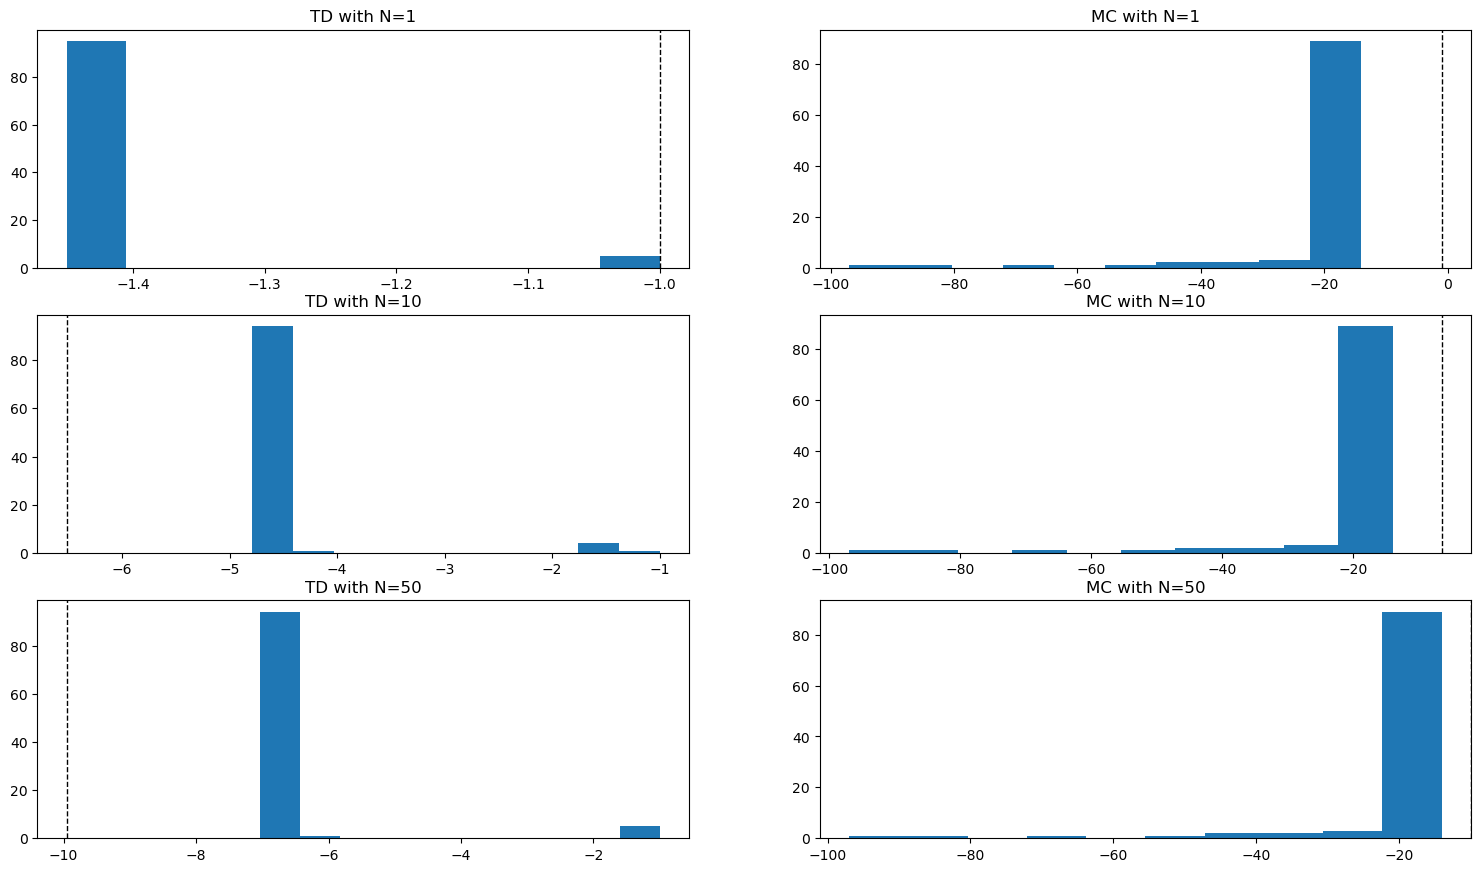

In [308]:
fig,((ax0,ax1),(ax2,ax3),(ax4,ax5)) = plt.subplots(3,2)
ax0.hist(tdt1)
ax0.axvline(v1, color='k', linestyle='dashed', linewidth=1)
ax0.set_title('TD with N=1')
ax2.hist(tdt10)
ax2.axvline(v10, color='k', linestyle='dashed', linewidth=1)
ax2.set_title('TD with N=10')
ax4.hist(tdt50)
ax4.axvline(v50, color='k', linestyle='dashed', linewidth=1)
ax4.set_title('TD with N=50')

ax1.hist(mct1)
ax1.axvline(v1, color='k', linestyle='dashed', linewidth=1)
ax1.set_title('MC with N=1')
ax3.hist(mct10)
ax3.axvline(v10, color='k', linestyle='dashed', linewidth=1)
ax3.set_title('MC with N=10')
ax5.hist(mct50)
ax5.axvline(v50, color='k', linestyle='dashed', linewidth=1)
ax5.set_title('MC with N=50')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show